In [1]:
! pip install statsmodels ipywidgets dask dask-ml > /dev/null


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import scipy
from scipy import stats as stats
import math
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import glob
import dask.dataframe as dd
from dask_ml.linear_model import LinearRegression
import dask
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

/root/venv/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
2024-06-10 04:38:02.269205: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 04:38:02.271479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 04:38:02.302697: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 04:38:0

In [3]:


# Directory containing your Parquet files
parquet_files_dir = '/work/data/by-vin-v11'

# List all Parquet files in the directory
parquet_files = [
    os.path.join(parquet_files_dir, f) 
    for f in os.listdir(parquet_files_dir) 
    if f.endswith('.parquet')
]

# Function to read a Parquet file and add a filename column
def read_parquet_with_filename(filepath):
    # Read the Parquet file
    df: dd.DataFrame = dd.read_parquet(filepath)
    # Add a column with the filename
    df['source_file'] = str(os.path.basename(filepath))

    # At the dataset; each vehicle seems to have changed their battery at the last year 
    half_idx = df.shape[0].compute() // 2
    print(f'{ half_idx = }')
    idx_new_battery = df.loc[half_idx:]['available_capacity (Ah)'].idxmax().compute()
    df = df.loc[idx_new_battery:]
    return df

ddf_list = [
    read_parquet_with_filename(f) for f in parquet_files
]  


 half_idx = 427295
 half_idx = 364424
 half_idx = 404735
 half_idx = 412766
 half_idx = 409176
 half_idx = 396566
 half_idx = 352479
 half_idx = 409783
 half_idx = 383934
 half_idx = 428096
 half_idx = 389372
 half_idx = 420905
 half_idx = 403744
 half_idx = 401459
 half_idx = 422268
 half_idx = 416094
 half_idx = 407601
 half_idx = 404385
 half_idx = 399248
 half_idx = 396030


In [4]:
ddf_list[9].head()


,record_time,soc,pack_voltage (V),charge_current (A),max_cell_voltage (V),min_cell_voltage (V),max_temperature (℃),min_temperature (℃),available_energy (kw),available_capacity (Ah),source_file,time_diff,new_session,charging_type
681955,2021-05-04 17:56:38,98.000000,379.700012,-41.50000,4.236,4.203,36,34,44.299999,133.220001,18.parquet,10.0,900001291,DC
681956,2021-05-05 00:56:23,40.799999,331.700012,-26.89999,3.697,3.676,30,28,18.420000,55.389999,18.parquet,25185.0,900001292,AC
681957,2021-05-05 00:56:33,40.799999,331.899994,-26.89999,3.698,3.678,30,28,18.459999,55.500000,18.parquet,10.0,900001292,AC
681958,2021-05-05 00:56:43,40.799999,331.899994,-26.89999,3.699,3.679,30,28,18.490000,55.599998,18.parquet,10.0,900001292,AC
681959,2021-05-05 00:56:53,40.799999,332.100006,-26.89999,3.700,3.679,30,28,18.510000,55.660000,18.parquet,10.0,900001292,AC


## Code: Grouping data into weeks

In [5]:

def compute_AC_DC_by_sessions(data, mode='M'):
    import pandas as pd
    import dask.dataframe as dd
    from datetime import datetime, timedelta

    weeks_data = data.copy()
    weeks_data['record_time'] = dd.to_datetime(weeks_data['record_time'])

    # Group by 'new_session' to get the minimum 'record_time' for each session
    sessions_by_week = weeks_data.groupby('new_session').min().reset_index()
    # Select the desired columns
    sessions_by_week = sessions_by_week[[
        'charging_type', 'record_time', 'new_session',
        ]]

    # Convert 'record_time' to datetime
    sessions_by_week['record_time'] = dd.to_datetime(sessions_by_week['record_time'])

    # Set 'record_time' as the index
    sessions_by_week = sessions_by_week.set_index('record_time')

    # Compute the DataFrame to bring it into memory
    sessions_by_week = sessions_by_week.compute()

    # Resample by week and count the 'new_session' column grouped by 'charging_type'
    sessions_result = sessions_by_week.groupby([pd.Grouper(freq=mode), 'charging_type']).new_session.count().unstack(fill_value=0)

    return dd.from_pandas(sessions_result)

sessions_results = [
    compute_AC_DC_by_sessions(data, mode='W')
    for data in ddf_list ]




In [6]:
sessions_results[0].head(20)

charging_type,AC,DC
record_time,,
2021-05-23,0,5
2021-05-30,0,14
2021-06-06,1,13
2021-06-13,0,8
2021-06-20,1,1
2021-06-27,1,12
2021-07-04,0,15
2021-07-11,0,17
2021-07-18,0,18


In [7]:

def compute_monthly_capacity_change(data, mode='M'):
    # Only consider data points from when almost fully charged
    df = data[data['soc'] >= 90].compute()  

    # Step 1: Resample the Data Weekly to get the maximum capacity
    df['record_time'] = pd.to_datetime(df['record_time'])
    df = df.set_index('record_time')

    df['full_capacity'] = df['available_capacity (Ah)'] / (df['soc']/ 100)

    # Resample to get the maximum available capacity for each week / month
    monthly_capacity = df['full_capacity'].resample(mode).max().dropna()

    # Step 2: Calculate Monthly Capacity Change
    monthly_capacity_change = monthly_capacity.diff().dropna()

    monthly = monthly_capacity_change.to_frame()
    monthly = monthly.rename(columns={'full_capacity': 'capacity_change'})
    monthly['capacity'] = monthly_capacity
    return dd.from_pandas(monthly)


# monthly = compute_monthly_capacity_change(data, mode='M')
# print(monthly.head())

monthly_ddfs = [
    compute_monthly_capacity_change(data, mode='M')
    for data in ddf_list ]

# weekly = compute_monthly_capacity_change(data, mode='W')

weekly_ddfs = [
    compute_monthly_capacity_change(data, mode='W')
    for data in ddf_list ]

In [8]:
print(weekly_ddfs[0].head())

             capacity_change    capacity
record_time                             
2021-05-30         -0.017853  136.477783
2021-06-06         -0.270889  136.206894
2021-06-13         -0.257111  135.949783
2021-06-20         -0.127274  135.822510
2021-06-27         -0.025574  135.796936


In [9]:
weekly_ddfs[0].head(200)

,capacity_change,capacity
record_time,,
2021-05-30,-0.017853,136.477783
2021-06-06,-0.270889,136.206894
2021-06-13,-0.257111,135.949783
2021-06-20,-0.127274,135.822510
2021-06-27,-0.025574,135.796936
2021-07-04,-0.262009,135.534927
2021-07-11,-0.159393,135.375534
2021-07-18,-0.396103,134.979431
2021-07-25,-0.267044,134.712387


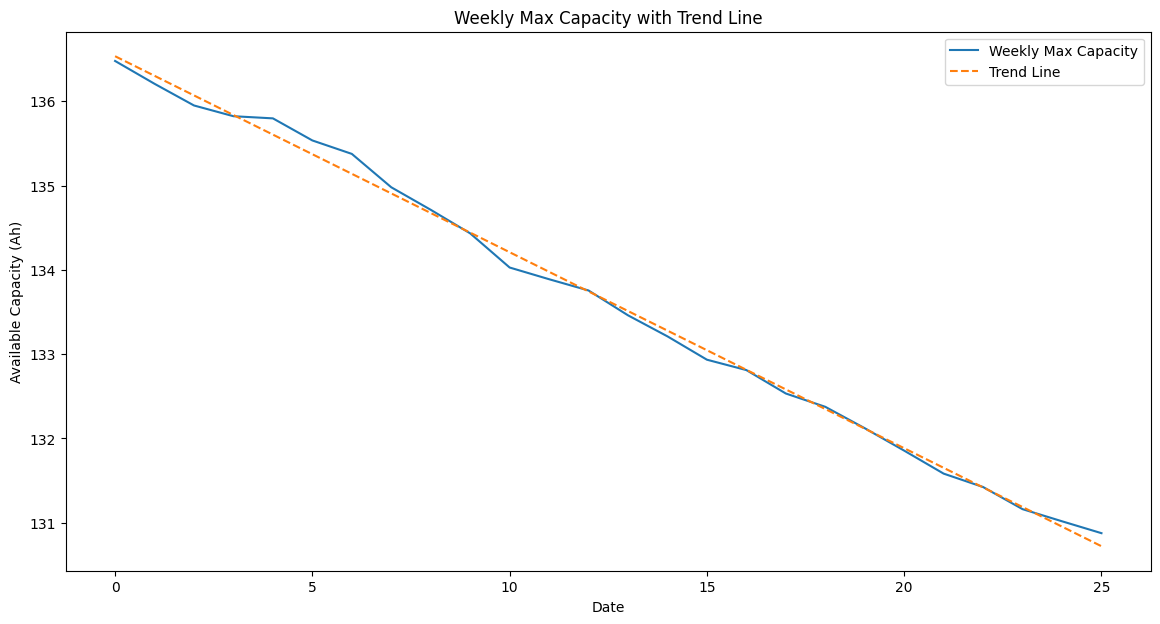

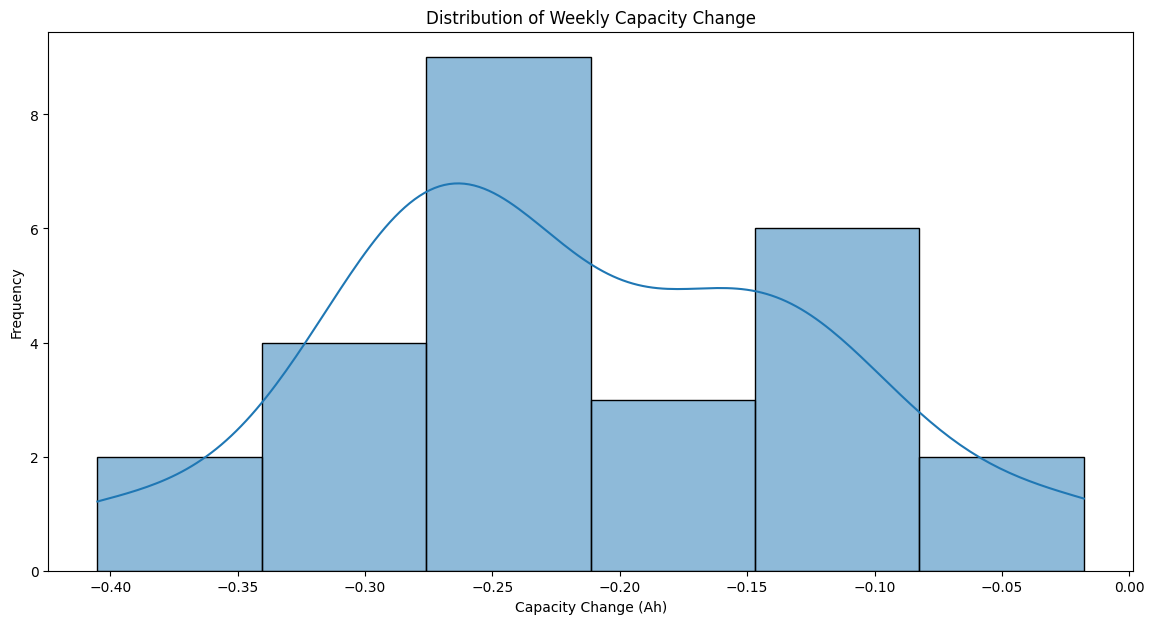

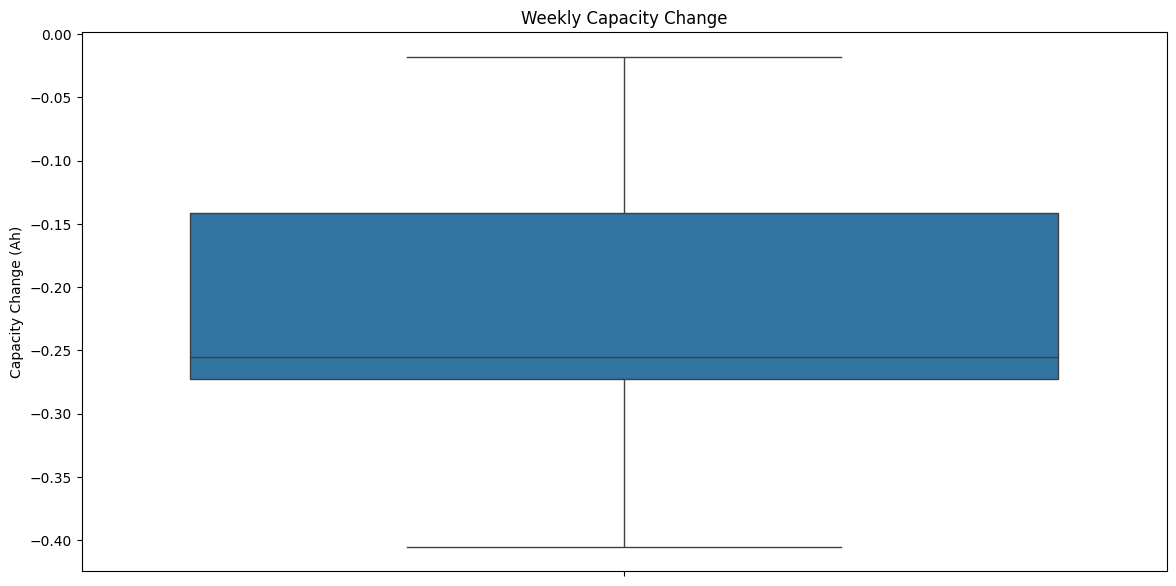

Summary Statistics for Weekly Max Capacity:
Dask DataFrame Structure:
              capacity_change capacity
npartitions=1                         
                      float64  float64
                          ...      ...
Dask Name: concat, 6 expressions
Expr=Concat(frames=[df['capacity_change'].describenumeric(split_every=False), df['capacity'].describenumeric(split_every=False)], axis=1)

Linear Regression Coefficients:
Intercept: 136.5340977856237
Slope: -0.23248987964075846

Trend Interpretation:
The trend line indicates a decreasing trend in weekly max capacity over time.


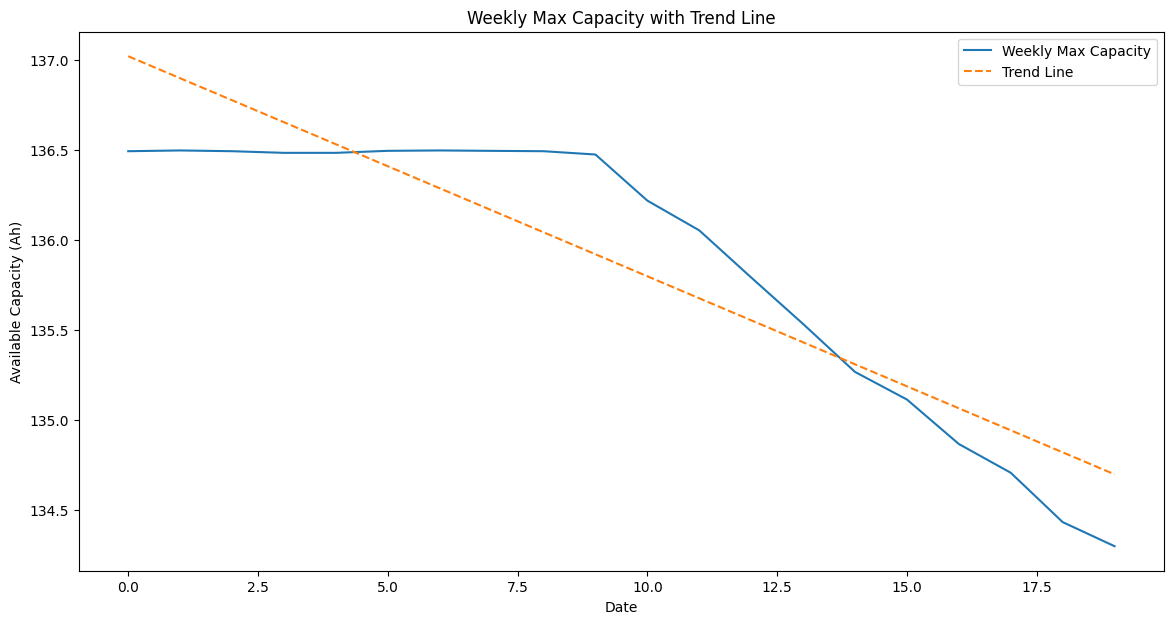

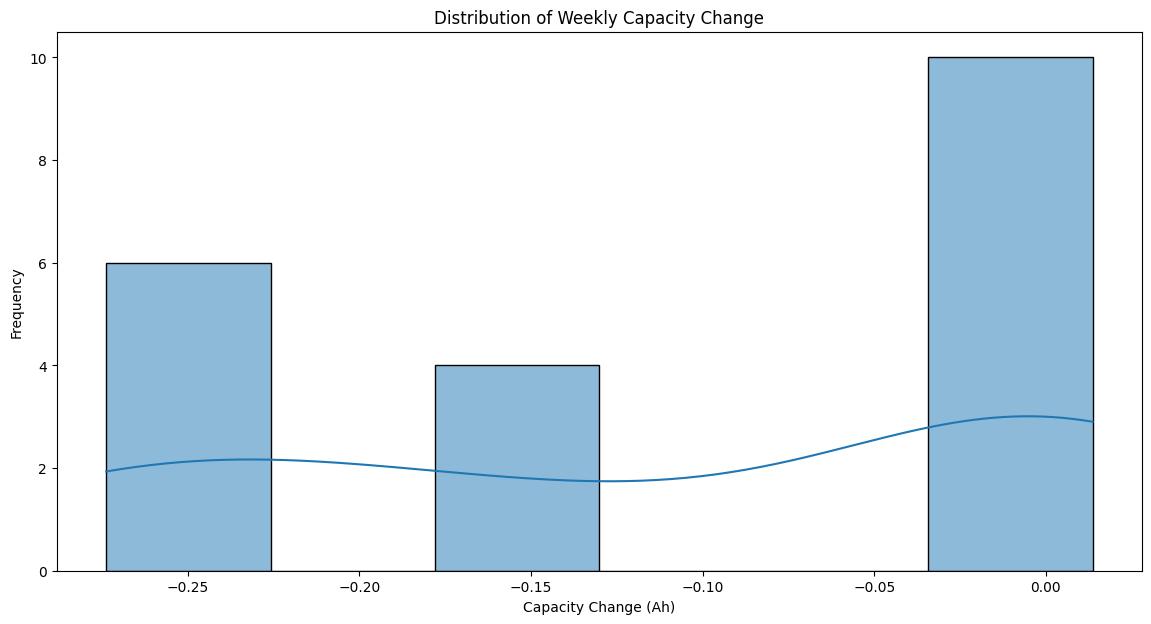

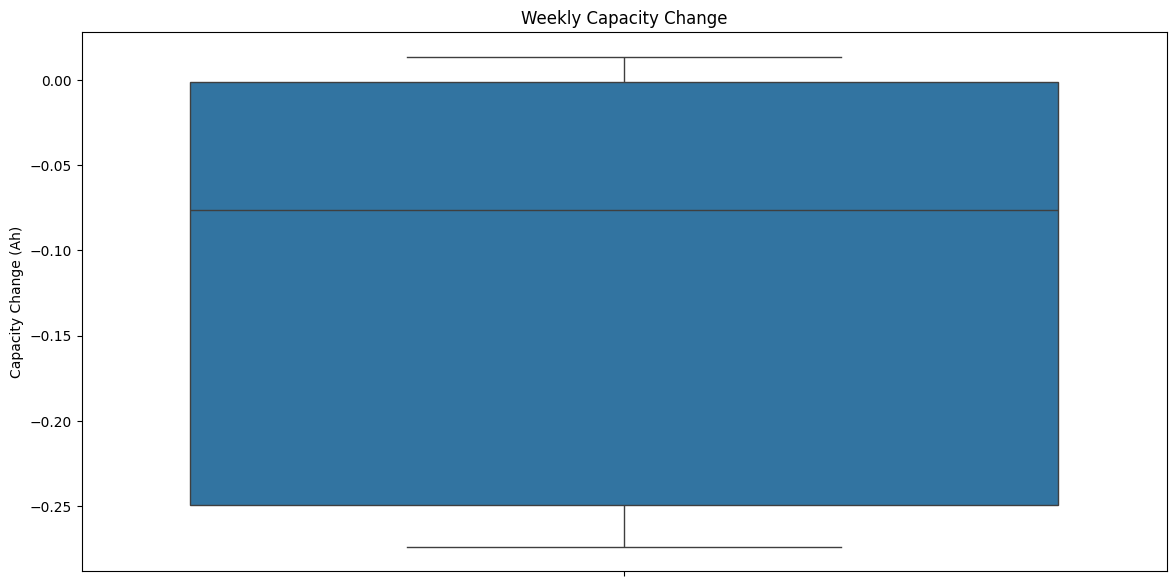

Summary Statistics for Weekly Max Capacity:
Dask DataFrame Structure:
              capacity_change capacity
npartitions=1                         
                      float64  float64
                          ...      ...
Dask Name: concat, 6 expressions
Expr=Concat(frames=[df['capacity_change'].describenumeric(split_every=False), df['capacity'].describenumeric(split_every=False)], axis=1)

Linear Regression Coefficients:
Intercept: 137.0184539794922
Slope: -0.12210267719469574

Trend Interpretation:
The trend line indicates a decreasing trend in weekly max capacity over time.


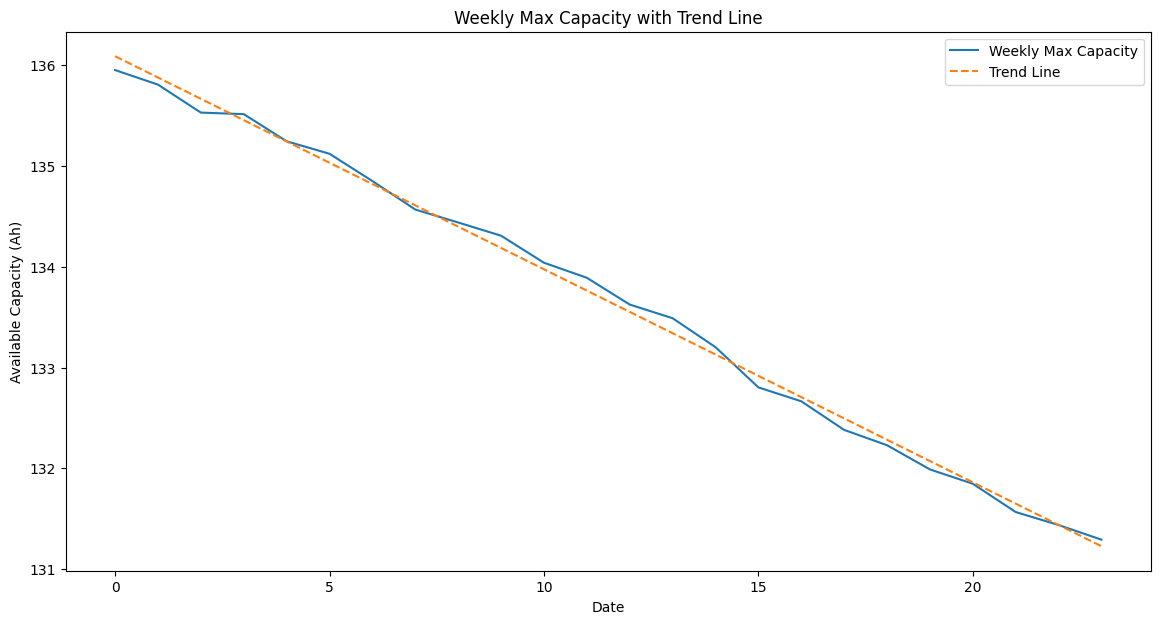

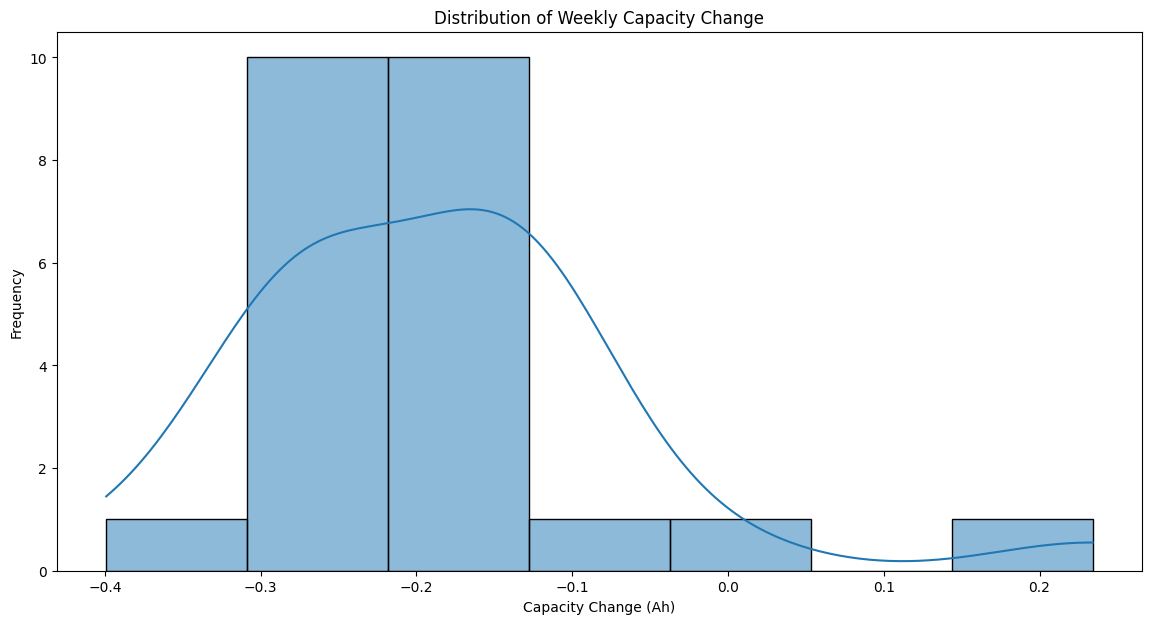

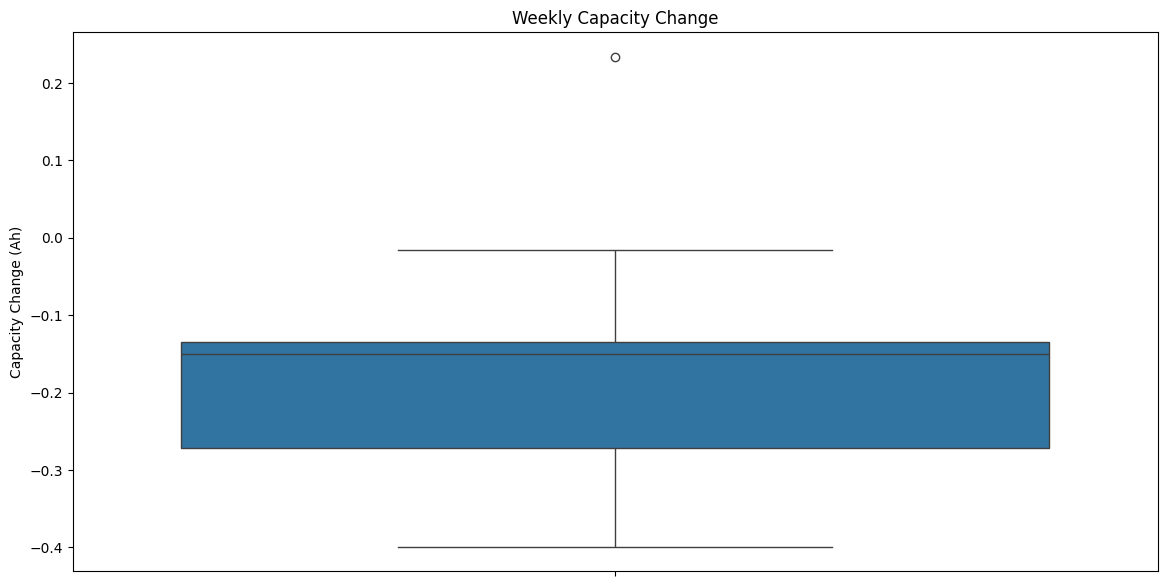

Summary Statistics for Weekly Max Capacity:
Dask DataFrame Structure:
              capacity_change capacity
npartitions=1                         
                      float64  float64
                          ...      ...
Dask Name: concat, 6 expressions
Expr=Concat(frames=[df['capacity_change'].describenumeric(split_every=False), df['capacity'].describenumeric(split_every=False)], axis=1)

Linear Regression Coefficients:
Intercept: 136.0871409098307
Slope: -0.21127661000127373

Trend Interpretation:
The trend line indicates a decreasing trend in weekly max capacity over time.


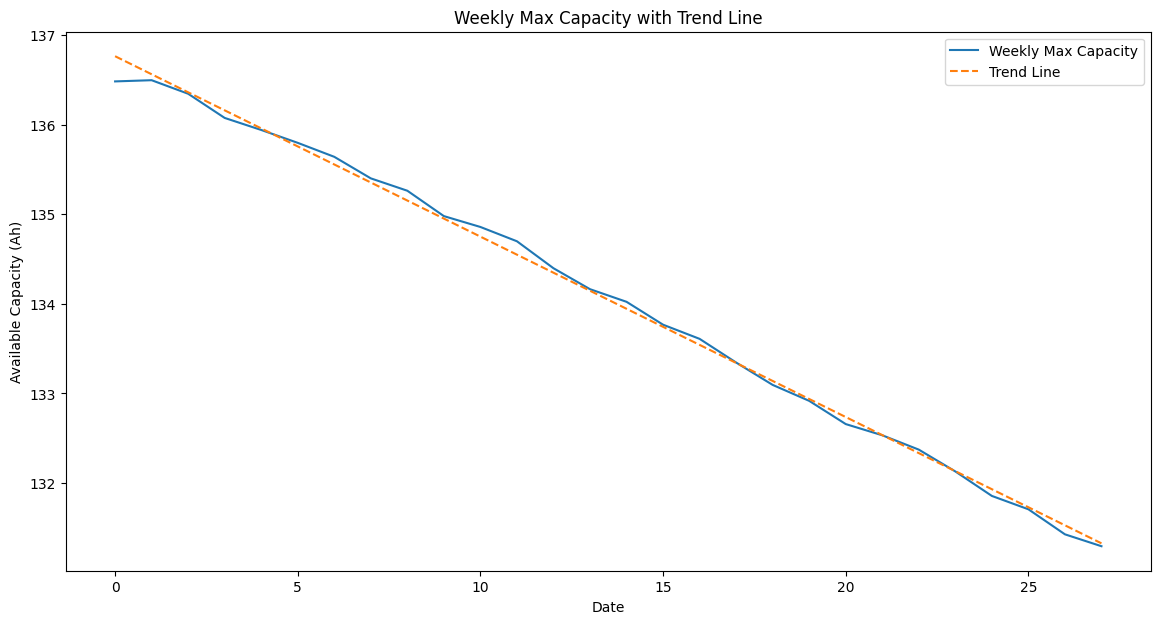

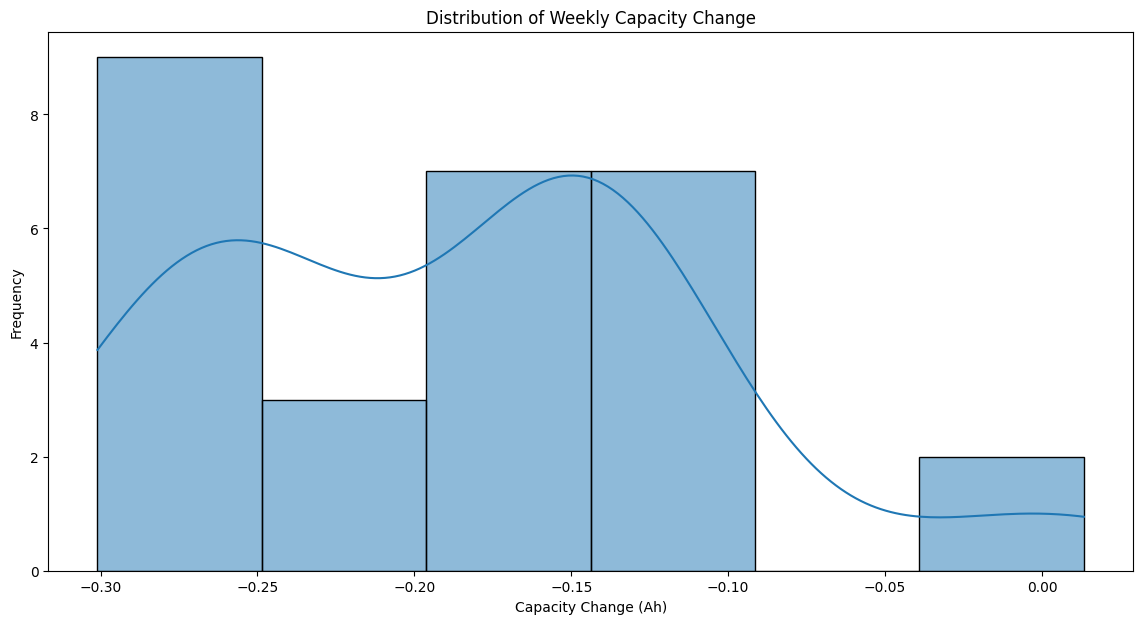

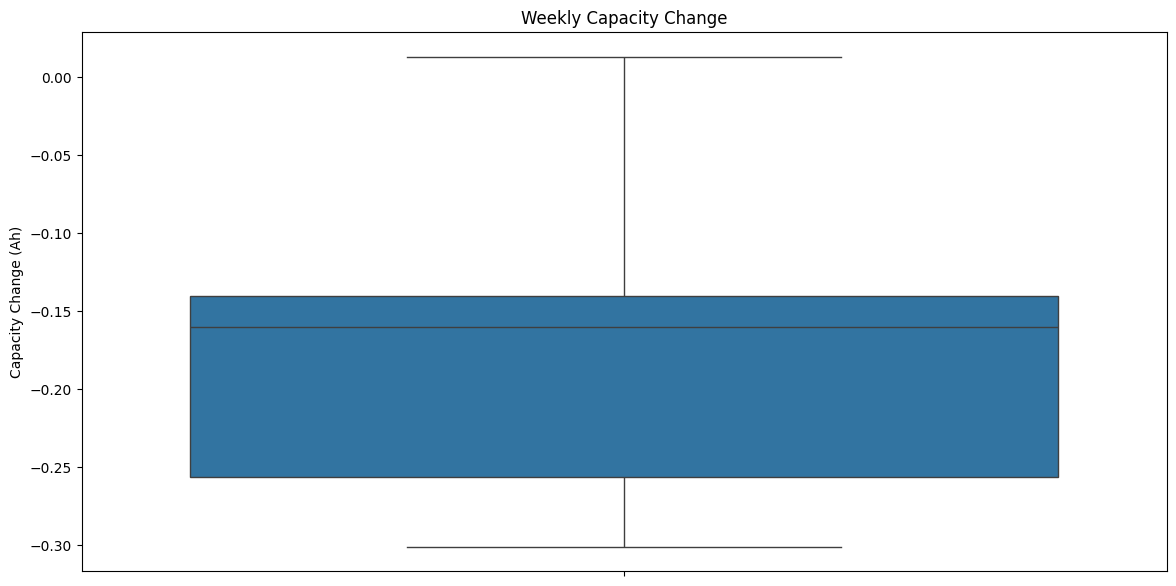

Summary Statistics for Weekly Max Capacity:
Dask DataFrame Structure:
              capacity_change capacity
npartitions=1                         
                      float64  float64
                          ...      ...
Dask Name: concat, 6 expressions
Expr=Concat(frames=[df['capacity_change'].describenumeric(split_every=False), df['capacity'].describenumeric(split_every=False)], axis=1)

Linear Regression Coefficients:
Intercept: 136.76336451939173
Slope: -0.20136466858878968

Trend Interpretation:
The trend line indicates a decreasing trend in weekly max capacity over time.


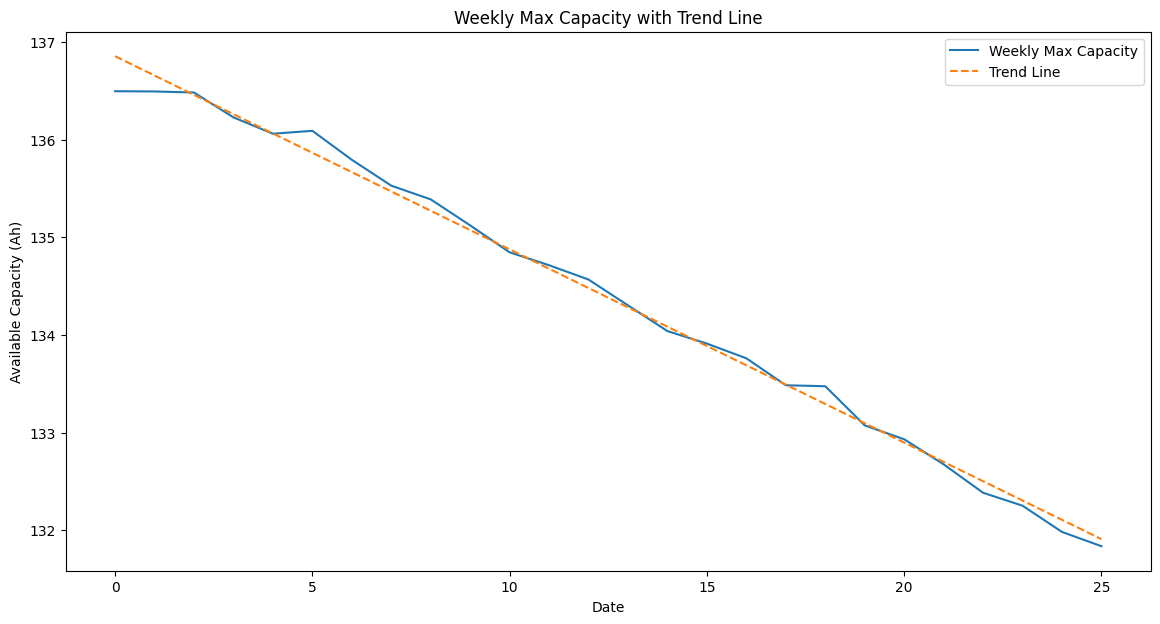

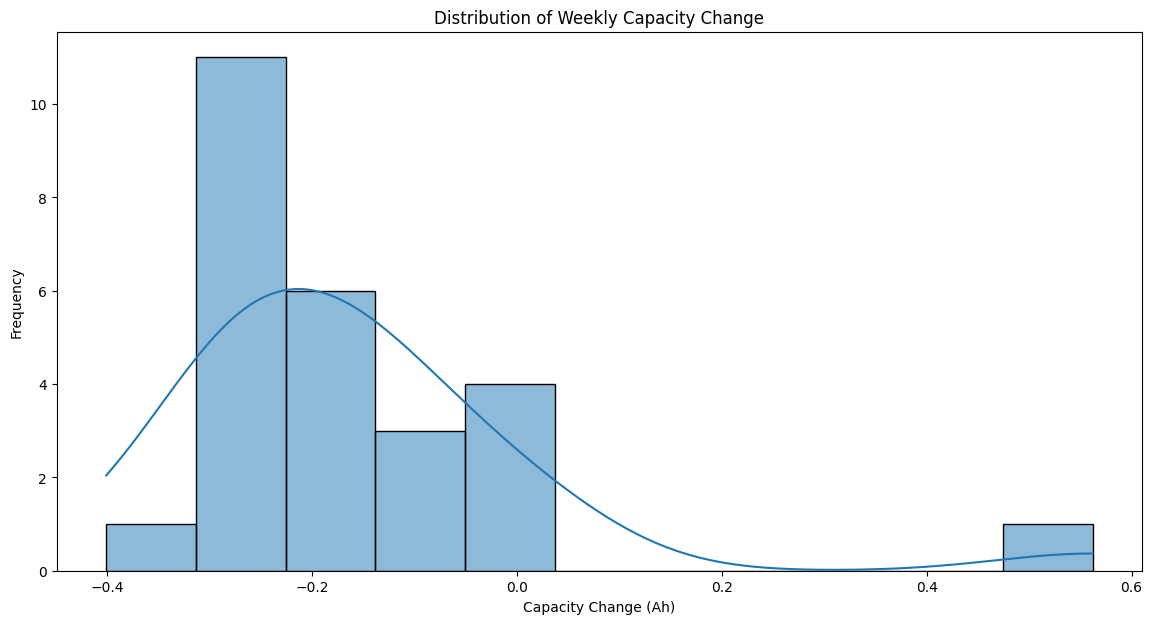

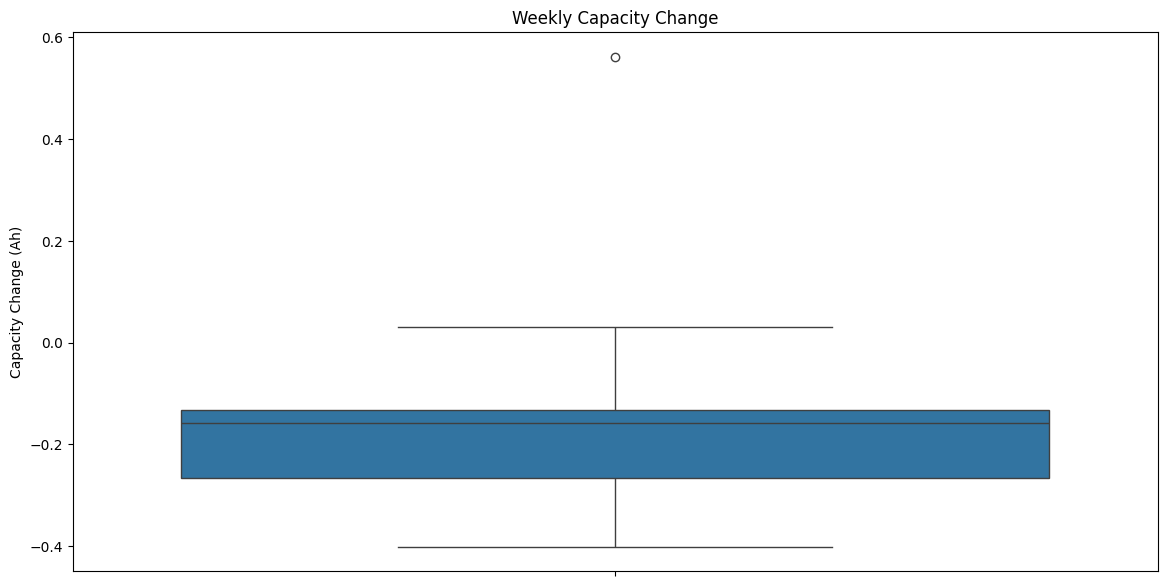

Summary Statistics for Weekly Max Capacity:
Dask DataFrame Structure:
              capacity_change capacity
npartitions=1                         
                      float64  float64
                          ...      ...
Dask Name: concat, 6 expressions
Expr=Concat(frames=[df['capacity_change'].describenumeric(split_every=False), df['capacity'].describenumeric(split_every=False)], axis=1)

Linear Regression Coefficients:
Intercept: 136.85418988089276
Slope: -0.1978316504323583

Trend Interpretation:
The trend line indicates a decreasing trend in weekly max capacity over time.


In [10]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

def draw_plot_t_capacity_trend(vin):

    weekly_capacity = weekly_ddfs[vin]

    # Week number
    X = np.arange(weekly_capacity.shape[0].compute()).reshape(-1, 1)

    y = weekly_capacity['capacity'].compute()

    # Perform linear regression
    reg = LinearRegression().fit(X, y)
    trend_line = reg.predict(X)

    # Step 4: Visualize the Results
    plt.figure(figsize=(14, 7))
    plt.plot(X, y, label='Weekly Max Capacity')
    plt.plot(X, trend_line, label='Trend Line', linestyle='--')
    plt.title('Weekly Max Capacity with Trend Line')
    plt.xlabel('Date')
    plt.ylabel('Available Capacity (Ah)')
    plt.legend()
    plt.show()

    # Show the weekly capacity change
    plt.figure(figsize=(14, 7))
    sns.histplot(weekly_capacity['capacity_change'], kde=True)
    plt.title('Distribution of Weekly Capacity Change')
    plt.xlabel('Capacity Change (Ah)')
    plt.ylabel('Frequency')
    plt.show()

    # Box plot of weekly capacity change
    plt.figure(figsize=(14, 7))
    sns.boxplot(y=weekly_capacity['capacity_change'])
    plt.title('Weekly Capacity Change')
    plt.ylabel('Capacity Change (Ah)')
    plt.show()

    # Textual Outputs
    # Summary statistics for weekly_capacity and weekly_capacity_change
    print("Summary Statistics for Weekly Max Capacity:")
    print(weekly_capacity.describe())


    # Linear Regression Coefficients
    print("\nLinear Regression Coefficients:")
    print(f"Intercept: {reg.intercept_}")
    print(f"Slope: {reg.coef_[0]}")

    # Textual interpretation of the trend
    print("\nTrend Interpretation:")
    if reg.coef_[0] > 0:
        print("The trend line indicates an increasing trend in weekly max capacity over time.")
    else:
        print("The trend line indicates a decreasing trend in weekly max capacity over time.")

    # # Monthly summaries
    # monthly_summary = weekly_capacity.resample('M').agg(['mean', 'max', 'min', 'std'])
    # print("\nMonthly Summary for Weekly Max Capacity:")
    # print(monthly_summary)

    # monthly_change_summary = weekly_capacity_change.resample('M').agg(['mean', 'max', 'min', 'std'])
    # print("\nMonthly Summary for Weekly Capacity Change:")
    # print(monthly_change_summary)


for i in range(5):
    draw_plot_t_capacity_trend(vin=i)

In [ ]:
# import pandas as pd
# import dask.dataframe as dd
# from datetime import datetime, timedelta
# from sklearn.linear_model import LinearRegression
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns


# sessions_by_week = data2.copy()
# # Assuming 'data2' is your DataFrame
# sessions_by_week['record_time'] = dd.to_datetime(sessions_by_week['record_time'])

# # Group by 'new_session' to get the minimum 'record_time' for each session
# sessions_by_week = sessions_by_week.groupby('new_session').min().reset_index()

# # Select the desired columns
# sessions_by_week = sessions_by_week[['charging_type', 'record_time', 'new_session']]

# # Convert 'record_time' to datetime
# sessions_by_week['record_time'] = dd.to_datetime(sessions_by_week['record_time'])

# # Set 'record_time' as the index
# sessions_by_week = sessions_by_week.set_index('record_time')

# # Compute the DataFrame to bring it into memory
# sessions_by_week = sessions_by_week.compute()

# # Resample by week and count the 'new_session' column grouped by 'charging_type'
# weekly_counts = sessions_by_week.groupby([pd.Grouper(freq='W'), 'charging_type']).new_session.count().unstack(fill_value=0)

# # Add weekly counts to the main DataFrame
# sessions_by_week['record_time'] = dd.to_datetime(sessions_by_week['record_time'])
# sessions_by_week = sessions_by_week.set_index('record_time')

# # Compute the main DataFrame to bring it into memory
# df = sessions_by_week.compute()

# # Resample to get the maximum available capacity for each week
# weekly_capacity = df['available_capacity (Ah)'].resample('W').max().dropna()

# # Calculate weekly capacity change
# weekly_capacity_change = weekly_capacity.diff().dropna()

# # Combine the weekly counts and weekly capacity change into a single DataFrame
# weekly_data = weekly_counts.join(weekly_capacity_change.rename('capacity_change')).dropna()

# print(weekly_data.head())


# weekly_data.loc[['AC', 'DC']].plot(kind='bar')

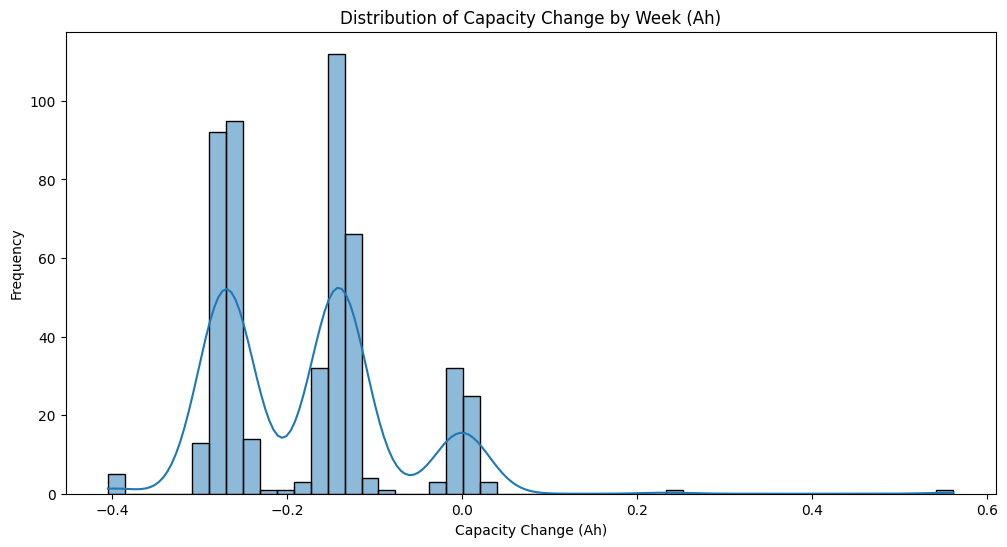

In [11]:
weekly = dd.concat([
    compute_monthly_capacity_change(ddf, mode='W') for ddf in ddf_list
])

plt.figure(figsize=(12, 6))
sns.histplot(weekly['capacity_change'], bins=50, kde=True)
plt.title('Distribution of Capacity Change by Week (Ah)')
plt.xlabel('Capacity Change (Ah)')
plt.ylabel('Frequency')
plt.show()

In [22]:
# Prepare the data for linear regression


def get_joined(vin):
    monthly = weekly_ddfs[vin]
    sessions_result = sessions_results[vin]
    merged = monthly.merge(right=sessions_result, left_index=True, right_on='record_time')

    print(merged.max().compute())

    merged = merged.loc[merged['capacity_change'] < 0]

    merged = merged.assign(
        charging_count= merged['AC'] + merged['DC']
    )

    merged = merged.compute()
    return merged

def get_X_y(vin):
    merged = get_joined(vin)
    columns = [ 'AC', 'DC', ]
    # columns = [ 'charging_count']

    X = merged[columns]

    y = merged['capacity_change']  # Response variable: change in capacity

    # Convert to Pandas DataFrame
    X = X.values.reshape(-1, len(columns))
    y = y.values
    # print(X)
    return X, y


Xys = [ get_X_y(vin) for vin in range(20) ]

X = np.concatenate([X for (X, _) in Xys], axis=0)
y = np.concatenate([y for (_, y) in Xys])

# print(X)

# sorted_indices = np.argsort(X, axis=0).flatten()

# X = X[sorted_indices]
# y = y[sorted_indices]

# Perform linear regression
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

# Regression coefficients
intercept = reg.intercept_
coefficients = reg.coef_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

# # Visualize the results
# plt.figure(figsize=(14, 7))
# plt.scatter(X, y, label='Actual Capacity Change')
# plt.scatter(X, y_pred, label='Predicted Capacity Change', linestyle='--')

# # plt.bar(merged.index, merged['DC'], label='DC')
# # plt.bar(merged.index, merged['AC'], label='AC')
# plt.title('Weekly Capacity Change: Actual vs Predicted')
# plt.xlabel('Date')
# plt.ylabel('Capacity Change (Ah)')
# plt.legend()
# plt.show()

# Show the regression summary
import statsmodels.api as sm

# Adding a constant for the intercept
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print(model.summary())





capacity_change     -0.017853
capacity           136.477783
AC                   1.000000
DC                  20.000000
dtype: float64
capacity_change      0.013641
capacity           136.495636
AC                   2.000000
DC                  18.000000
dtype: float64
capacity_change      0.234055
capacity           135.949783
AC                   1.000000
DC                  20.000000
dtype: float64
capacity_change      0.013351
capacity           136.495636
AC                   1.000000
DC                  20.000000
dtype: float64
capacity_change      0.561905
capacity           136.495636
AC                   2.000000
DC                  18.000000
dtype: float64
capacity_change     -0.002930
capacity           135.668869
AC                   1.000000
DC                  19.000000
dtype: float64
capacity_change      0.010147
capacity           136.500000
AC                   2.000000
DC                  20.000000
dtype: float64
capacity_change     -0.005386
capacity           136.07

capacity_change     -0.017853
capacity           136.477783
AC                   1.000000
DC                  20.000000
dtype: float64
capacity_change      0.013641
capacity           136.495636
AC                   2.000000
DC                  18.000000
dtype: float64
capacity_change      0.234055
capacity           135.949783
AC                   1.000000
DC                  20.000000
dtype: float64
capacity_change      0.013351
capacity           136.495636
AC                   1.000000
DC                  20.000000
dtype: float64
capacity_change      0.561905
capacity           136.495636
AC                   2.000000
DC                  18.000000
dtype: float64
capacity_change     -0.002930
capacity           135.668869
AC                   1.000000
DC                  19.000000
dtype: float64
capacity_change      0.010147
capacity           136.500000
AC                   2.000000
DC                  20.000000
dtype: float64
capacity_change     -0.005386
capacity           136.07

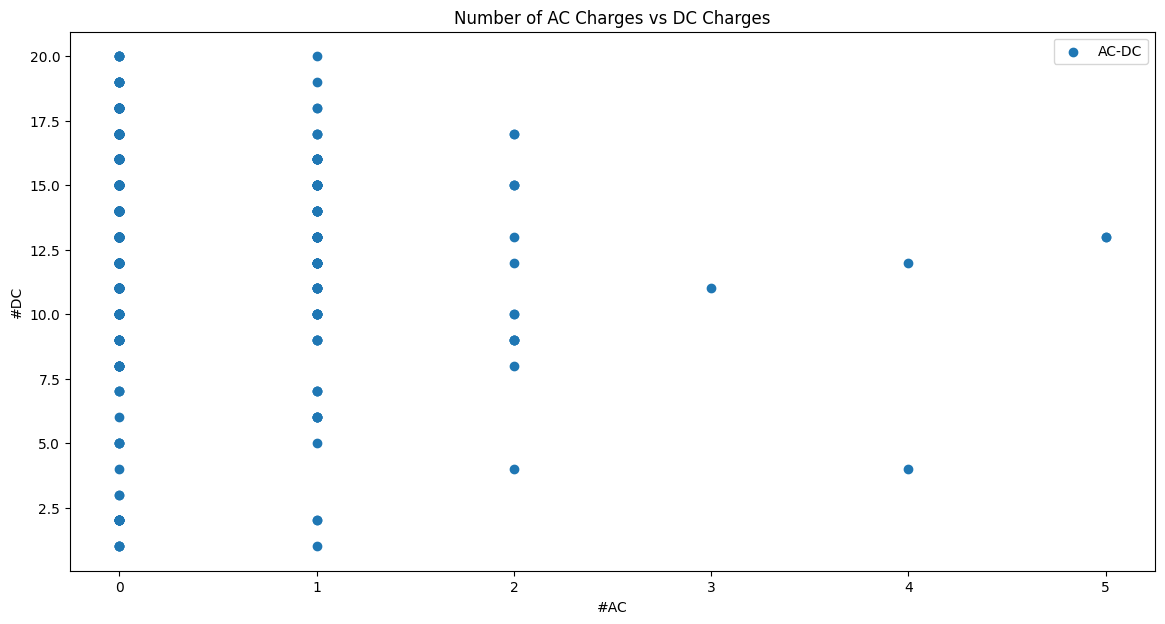

In [13]:
all_joined = dd.concat([get_joined(vin) for vin in range(20)])

# vehicle_0_joined = get_joined(0)

# Visualize the results
plt.figure(figsize=(14, 7))
plt.scatter(all_joined['AC'], all_joined['DC'], label='AC-DC')

# plt.bar(merged.index, merged['DC'], label='DC')
# plt.bar(merged.index, merged['AC'], label='AC')
plt.title('Number of AC Charges vs DC Charges')
plt.xlabel('#AC')
plt.ylabel('#DC')
plt.legend()
plt.show()


The regression results indicate that the counts of AC and DC charging sessions do not significantly explain the changes in battery capacity. Both the R-squared and adjusted R-squared values are very low, suggesting that the model does not fit the data well. Additionally, the p-values for the coefficients of AC and DC are high, indicating that neither predictor is statistically significant. The residuals exhibit non-normality, skewness, and kurtosis, suggesting that the assumptions of the OLS regression are not fully met. This model may require further refinement or consideration of additional variables to improve its explanatory power.

In [24]:
data = dd.read_parquet('data/data-merged-v7-partial.parquet')
df = data.compute()

ArrowInvalid: Error creating dataset. Could not read schema from '/datasets/_deepnote_work/data/data-merged-v7-partial.parquet/part.0.parquet'. Is this a 'parquet' file?: Could not open Parquet input source '/datasets/_deepnote_work/data/data-merged-v7-partial.parquet/part.0.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df is your DataFrame
print("Columns in the DataFrame:", df.columns)
print(df.head())

# Check for specific columns
required_columns = ['voltage_variation', 'capacity_decrease']
for col in required_columns:
    if col not in df.columns:
        print(f"Column '{col}' not found in the DataFrame")

# Assuming df has 'voltage_variation' and 'capacity_decrease' columns
# If the actual column names are different, replace them accordingly
if 'voltage_variation' in df.columns and 'capacity_decrease' in df.columns:
    X = df[['voltage_variation']]
    y = df['capacity_decrease']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Set the parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1
    }

    # Train the model
    gbm = lgb.train(params, train_data, valid_sets=[train_data, test_data], early_stopping_rounds=10)

    # Predict and evaluate
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'RMSE: {rmse}')
else:
    print("Required columns are not found in the DataFrame.")


ModuleNotFoundError: No module named 'lightgbm'

In [25]:
!pip install lightgbm==4.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 78.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [32]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df is your DataFrame
print("Columns in the DataFrame:", df.columns)
print(df.head())

# Calculate the standard deviation of the voltage
df['voltage_std'] = df[['max_cell_voltage (V)', 'min_cell_voltage (V)']].std(axis=1)

# Compute 'capacity_decrease' as the difference in 'available_capacity (Ah)' over time
df['capacity_decrease'] = df['available_capacity (Ah)'].diff().fillna(0)

# Filter out non-decreasing capacity changes to focus on decreases only
df = df[df['capacity_decrease'] < 0]

# Check for specific columns
required_columns = ['voltage_std', 'capacity_decrease']
for col in required_columns:
    if col not in df.columns:
        print(f"Column '{col}' not found in the DataFrame")

# Assuming df has 'voltage_std' and 'capacity_decrease' columns
if 'voltage_std' in df.columns and 'capacity_decrease' in df.columns:
    X = df[['voltage_std']]
    y = df['capacity_decrease']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Set the parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1
    }

    # Custom callback to display RMSE at each iteration
    def rmse_callback(env):
        print(f"Iteration: {env.iteration}, Training RMSE: {env.evaluation_result_list[0][2]}, Validation RMSE: {env.evaluation_result_list[1][2]}")

    # Train the model with early stopping using a callback
    gbm = lgb.train(params, train_data, valid_sets=[train_data, test_data], callbacks=[rmse_callback, lgb.early_stopping(stopping_rounds=10)])

    # Predict and evaluate
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'Final RMSE: {rmse}')
else:
    print("Required columns are not found in the DataFrame.")


Columns in the DataFrame: Index(['record_time', 'soc', 'pack_voltage (V)', 'charge_current (A)',
       'max_cell_voltage (V)', 'min_cell_voltage (V)', 'max_temperature (℃)',
       'min_temperature (℃)', 'available_energy (kw)',
       'available_capacity (Ah)', 'source_file', 'time_diff', 'new_session',
       'charging_type'],
      dtype='object')
                            record_time        soc  pack_voltage (V)  \
__null_dask_index__                                                    
0                   2019-07-24 23:00:08  51.599998        338.600006   
1                   2019-07-24 23:00:16  51.599998        339.100006   
2                   2019-07-24 23:00:24  51.599998        339.399994   
3                   2019-07-24 23:00:32  52.000000        339.700012   
4                   2019-07-24 23:00:40  52.000000        339.899994   

                     charge_current (A)  max_cell_voltage (V)  \
__null_dask_index__                                             
0          

Columns in the DataFrame: Index(['record_time', 'soc', 'pack_voltage (V)', 'charge_current (A)',
       'max_cell_voltage (V)', 'min_cell_voltage (V)', 'max_temperature (℃)',
       'min_temperature (℃)', 'available_energy (kw)',
       'available_capacity (Ah)', 'source_file', 'time_diff', 'new_session',
       'charging_type'],
      dtype='object')
                            record_time        soc  pack_voltage (V)  \
__null_dask_index__                                                    
0                   2019-07-24 23:00:08  51.599998        338.600006   
1                   2019-07-24 23:00:16  51.599998        339.100006   
2                   2019-07-24 23:00:24  51.599998        339.399994   
3                   2019-07-24 23:00:32  52.000000        339.700012   
4                   2019-07-24 23:00:40  52.000000        339.899994   

                     charge_current (A)  max_cell_voltage (V)  \
__null_dask_index__                                             
0          

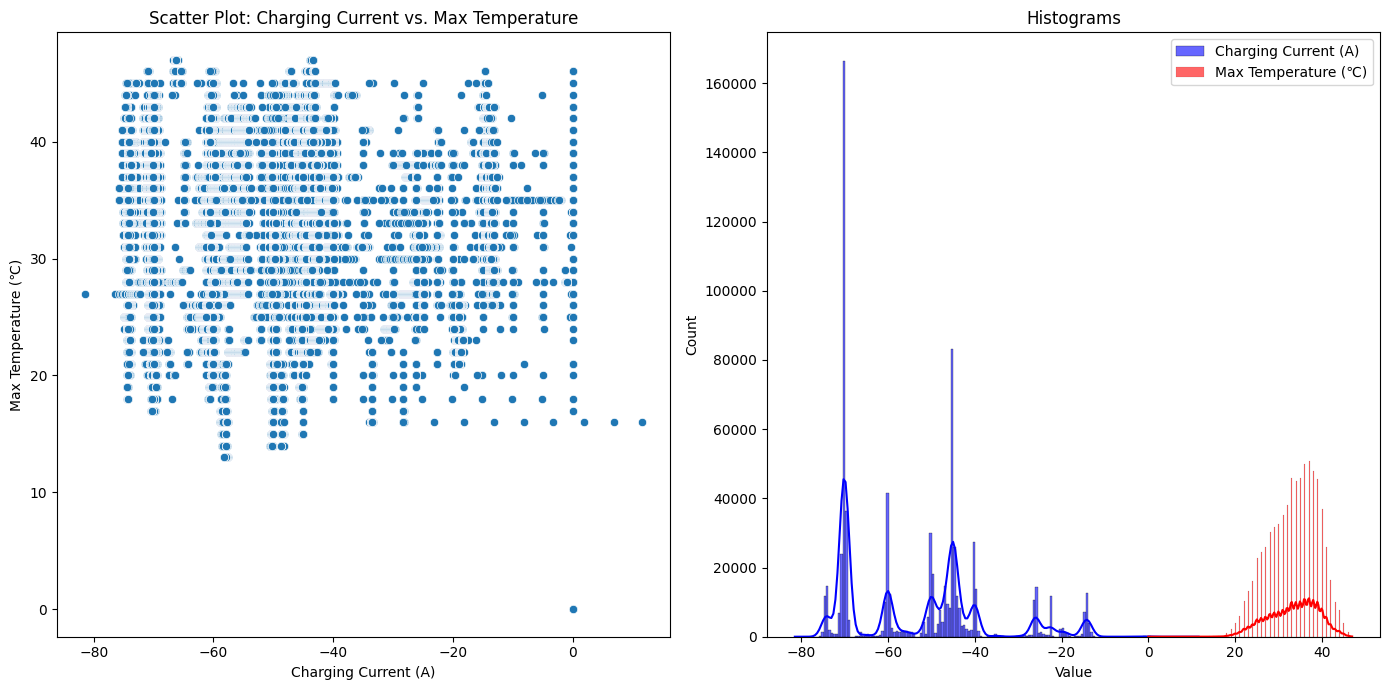

Correlation coefficient between Charging Current and Max Temperature: -0.04
P-value: 2.22e-258
The negative correlation indicates that higher charging currents are associated with lower temperatures.
The correlation is statistically significant.

Higher charging currents can result in increased temperatures due to the higher energy input. 
This increased temperature can accelerate the aging process of the battery by promoting faster chemical reactions within the cells. 
Maintaining lower charging currents or implementing efficient cooling systems can help mitigate these effects and prolong battery life.



In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

df = pd.read_parquet('data/by-vin-v11/10.parquet')

# Assuming df is your DataFrame already loaded with necessary columns
print("Columns in the DataFrame:", df.columns)
print(df.head())

# Step 1: Ensure data types are correct and handle missing values if any
df['charge_current (A)'] = pd.to_numeric(df['charge_current (A)'], errors='coerce')
df['max_temperature (℃)'] = pd.to_numeric(df['max_temperature (℃)'], errors='coerce')

# Drop rows with missing values in the columns of interest
df = df.dropna(subset=['charge_current (A)', 'max_temperature (℃)'])

# Step 2: Descriptive Statistics
print("Descriptive Statistics for Charging Current (A):")
print(df['charge_current (A)'].describe())
print("\nDescriptive Statistics for Maximum Temperature (℃):")
print(df['max_temperature (℃)'].describe())

# Step 3: Visualization
plt.figure(figsize=(14, 7))

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['charge_current (A)'], y=df['max_temperature (℃)'])
plt.title('Scatter Plot: Charging Current vs. Max Temperature')
plt.xlabel('Charging Current (A)')
plt.ylabel('Max Temperature (℃)')

# Histograms
plt.subplot(1, 2, 2)
sns.histplot(df['charge_current (A)'], kde=True, label='Charging Current (A)', color='blue', alpha=0.6)
sns.histplot(df['max_temperature (℃)'], kde=True, label='Max Temperature (℃)', color='red', alpha=0.6)
plt.title('Histograms')
plt.xlabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

# Step 4: Correlation Analysis
correlation, p_value = pearsonr(df['charge_current (A)'], df['max_temperature (℃)'])
print(f'Correlation coefficient between Charging Current and Max Temperature: {correlation:.2f}')
print(f'P-value: {p_value:.2e}')

# Step 5: Interpretation
if correlation > 0:
    print("The positive correlation indicates that higher charging currents are associated with higher temperatures.")
else:
    print("The negative correlation indicates that higher charging currents are associated with lower temperatures.")

if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

print("""
Higher charging currents can result in increased temperatures due to the higher energy input. 
This increased temperature can accelerate the aging process of the battery by promoting faster chemical reactions within the cells. 
Maintaining lower charging currents or implementing efficient cooling systems can help mitigate these effects and prolong battery life.
""")


A descriptive analysis was done focusing on the relationship between charge current and maximum temperature. We wanted to show a potential correlation between them, hypothesizing that higher charging currents would lead to increased temperatures. Based on the result, the correlation coefficient between them was -0.04, indicating a very weak negative relationship. But, the correlation is statistically significant, shown by the extremely low p-value (2.22e-258), showing that higher charging currents are associated with lower temperatures, contrary to our hypothesis.

Session ID: 33 (AC)
              record_time        soc  pack_voltage (V)  charge_current (A)  \
27387 2019-08-14 11:47:53  32.799999        328.299988           -26.20001   
27388 2019-08-14 11:48:01  32.799999        328.500000           -26.20001   
27389 2019-08-14 11:48:09  32.799999        328.500000           -26.20001   
27390 2019-08-14 11:48:17  32.799999        328.600006           -26.10001   
27391 2019-08-14 11:48:25  32.799999        328.600006           -26.10001   

       max_cell_voltage (V)  min_cell_voltage (V)  max_temperature (℃)  \
27387                 3.656                 3.646                   35   
27388                 3.657                 3.647                   35   
27389                 3.658                 3.647                   35   
27390                 3.659                 3.649                   35   
27391                 3.660                 3.649                   35   

       min_temperature (℃)  available_energy (kw)  available_capac

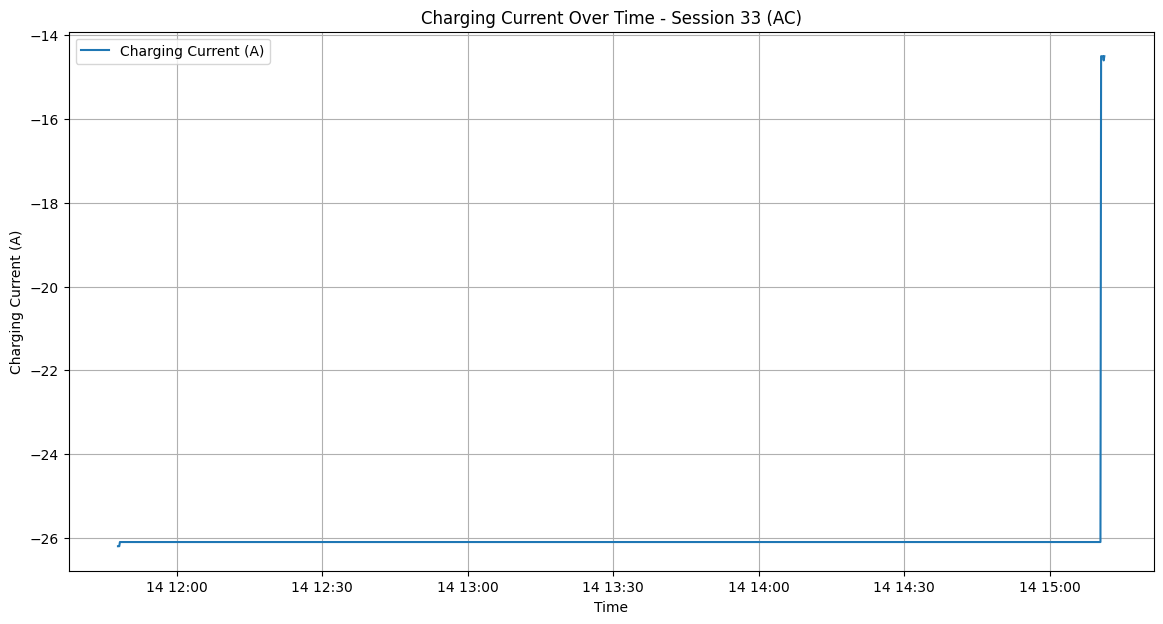

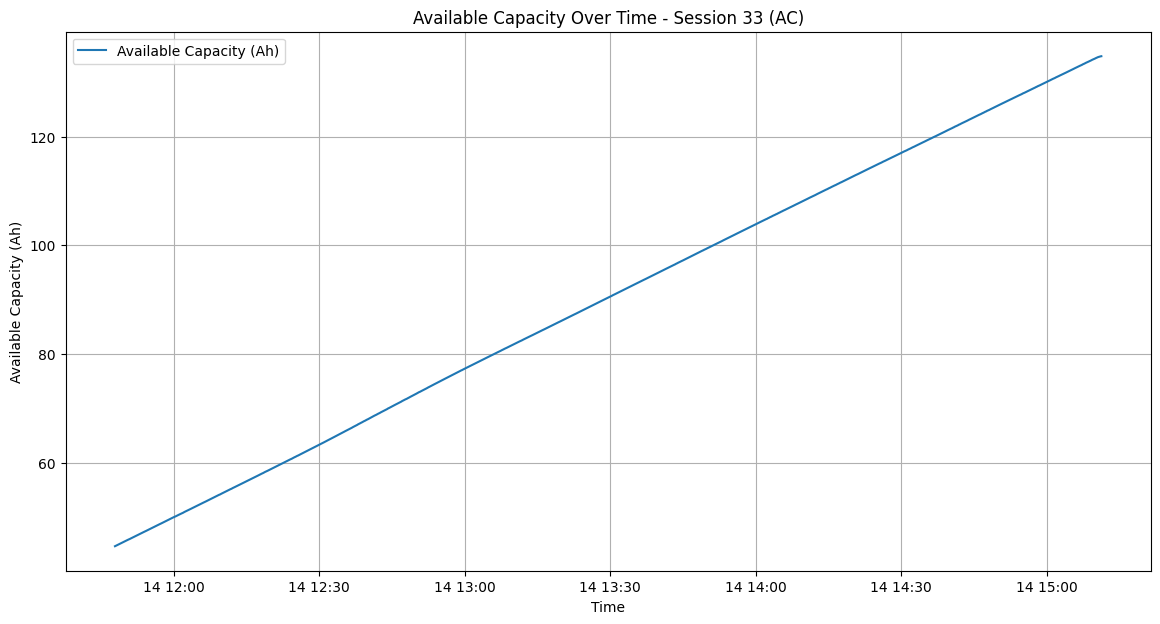

Session ID: 20 (DC)
              record_time   soc  pack_voltage (V)  charge_current (A)  \
17029 2019-08-06 05:16:44  12.4        323.299988          -70.200012   
17030 2019-08-06 05:16:52  12.8        323.600006          -70.100014   
17031 2019-08-06 05:17:00  12.8        323.799988          -70.100014   
17032 2019-08-06 05:17:08  13.2        323.899994          -70.100014   
17033 2019-08-06 05:17:16  13.2        324.100006          -70.200012   

       max_cell_voltage (V)  min_cell_voltage (V)  max_temperature (℃)  \
17029                 3.613                 3.586                   37   
17030                 3.615                 3.589                   37   
17031                 3.618                 3.592                   37   
17032                 3.619                 3.593                   37   
17033                 3.621                 3.595                   37   

       min_temperature (℃)  available_energy (kw)  available_capacity (Ah)  \
17029             

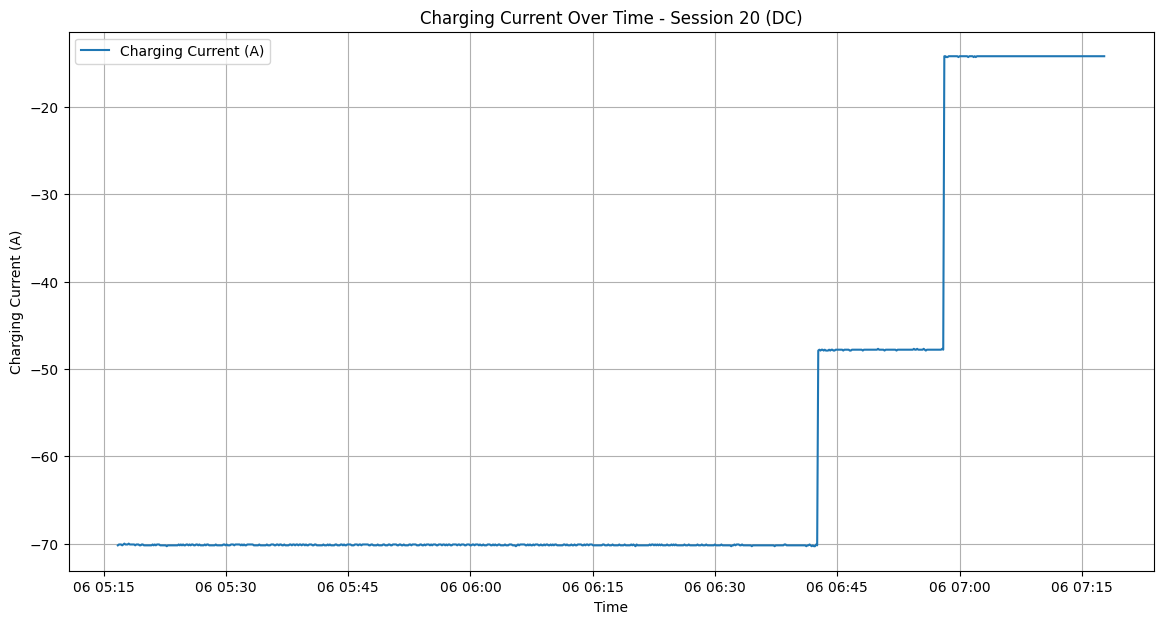

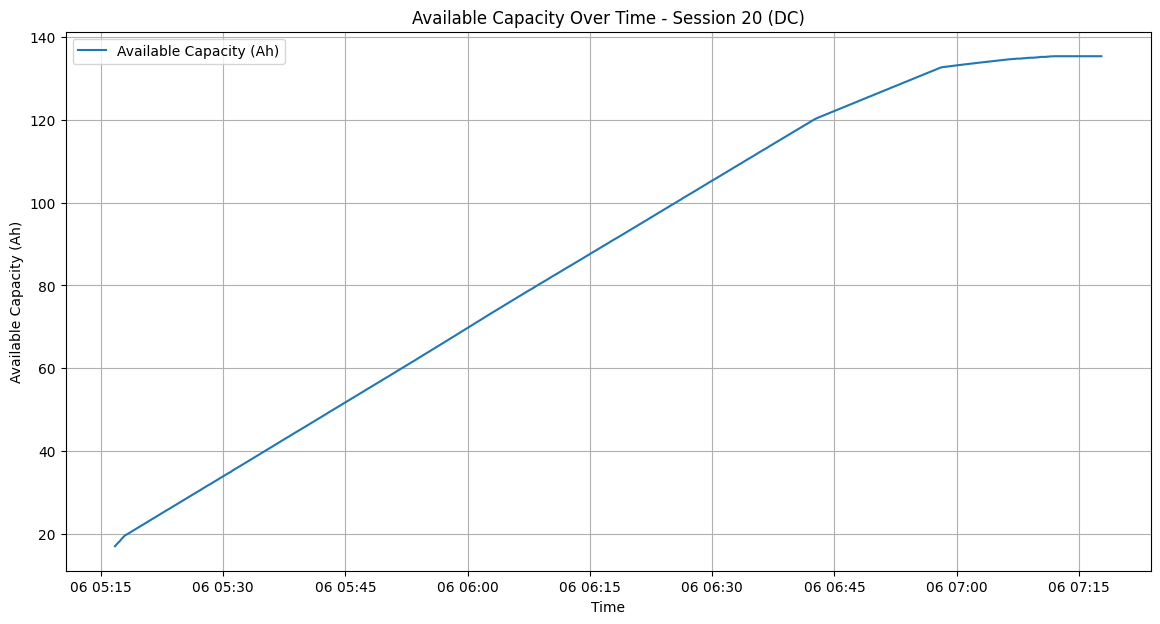

In [ ]:
import os
import dask.dataframe as dd
import matplotlib.pyplot as plt

def plot_session_time_series(data, session_id, title):
    session_data = data[data['new_session'] == session_id].compute()
    session_data = session_data.sort_values(by='record_time')
    print(f"Session ID: {session_id} ({title})")
    print(session_data.head())
    print(session_data.describe())

    plt.figure(figsize=(14, 7))
    plt.plot(session_data['record_time'], session_data['charge_current (A)'], label='Charging Current (A)')
    plt.title(f'Charging Current Over Time - Session {session_id} ({title})')
    plt.xlabel('Time')
    plt.ylabel('Charging Current (A)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(session_data['record_time'], session_data['available_capacity (Ah)'], label='Available Capacity (Ah)')
    plt.title(f'Available Capacity Over Time - Session {session_id} ({title})')
    plt.xlabel('Time')
    plt.ylabel('Available Capacity (Ah)')
    plt.legend()
    plt.grid(True)
    plt.show()

parquet_files_dir = '/work/data/by-vin-v11'
parquet_files = [
    os.path.join(parquet_files_dir, f) 
    for f in os.listdir(parquet_files_dir) 
    if f.endswith('.parquet')
]

data = dd.concat([dd.read_parquet(f) for f in parquet_files])
data['new_session'] = data['new_session'].fillna(-1).astype(int)
ac_sessions = data[data['charging_type'] == 'AC']['new_session'].unique().compute()
dc_sessions = data[data['charging_type'] == 'DC']['new_session'].unique().compute()
ac_session_id = next((session for session in ac_sessions if session != -1), None)
dc_session_id = next((session for session in dc_sessions if session != -1), None)

if ac_session_id is not None:
    plot_session_time_series(data, ac_session_id, 'AC')
else:
    print("No valid AC session found.")

if dc_session_id is not None:
    plot_session_time_series(data, dc_session_id, 'DC')
else:
    print("No valid DC session found.")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=119995d2-42f9-4679-a55c-cd52fa6a2421' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>